In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the Teams data
teams_df = pd.read_csv('/Users/leili/Desktop/Fall 2024/Capstone/lahman_1871-2023_csv/lahman_1871-2023_csv/Teams.csv')

# Load player statistics
batting_df = pd.read_csv('/Users/leili/Desktop/Fall 2024/Capstone/lahman_1871-2023_csv/lahman_1871-2023_csv/Batting.csv')
pitching_df = pd.read_csv('/Users/leili/Desktop/Fall 2024/Capstone/lahman_1871-2023_csv/lahman_1871-2023_csv/Pitching.csv')

# Load salaries data
salaries_df = pd.read_csv('/Users/leili/Desktop/Fall 2024/Capstone/lahman_1871-2023_csv/lahman_1871-2023_csv/Salaries.csv')

# Load awards data
awards_players_df = pd.read_csv('/Users/leili/Desktop/Fall 2024/Capstone/lahman_1871-2023_csv/lahman_1871-2023_csv/AwardsPlayers.csv')
awards_managers_df = pd.read_csv('/Users/leili/Desktop/Fall 2024/Capstone/lahman_1871-2023_csv/lahman_1871-2023_csv/AwardsManagers.csv')

# Load managers data
managers_df = pd.read_csv('/Users/leili/Desktop/Fall 2024/Capstone/lahman_1871-2023_csv/lahman_1871-2023_csv/Managers.csv')


In [3]:
# Convert 'DivWin', 'WCWin', 'LgWin', and 'WSWin' to binary
binary_cols = ['DivWin', 'WCWin', 'LgWin', 'WSWin']
for col in binary_cols:
    teams_df[col] = teams_df[col].map({'Y': 1, 'N': 0})


In [4]:
# Create 'Playoff' indicator
teams_df['Playoff'] = teams_df[['DivWin', 'WCWin']].max(axis=1)

In [5]:
# Filter data from 1980 onward to focus on modern baseball era
teams_df = teams_df[teams_df['yearID'] >= 1980].reset_index(drop=True)

In [6]:
# Merge batting stats with salaries to get salary information for players
batting_df = batting_df.merge(salaries_df, on=['playerID', 'yearID', 'teamID'], how='left')

# Calculate total team batting stats per year
team_batting_stats = batting_df.groupby(['teamID', 'yearID']).agg({
    'H': 'sum',
    'HR': 'sum',
    'RBI': 'sum',
    'SB': 'sum',
    'BB': 'sum',
    'SO': 'sum',
    'salary': 'sum'
}).reset_index()

# Rename columns for clarity
team_batting_stats.rename(columns={
    'H': 'Team_Hits',
    'HR': 'Team_HR',
    'RBI': 'Team_RBI',
    'SB': 'Team_SB',
    'BB': 'Team_BB',
    'SO': 'Team_SO',
    'salary': 'Team_Salary'
}, inplace=True)

In [7]:
# Calculate total team pitching stats per year
team_pitching_stats = pitching_df.groupby(['teamID', 'yearID']).agg({
    'W': 'sum',
    'L': 'sum',
    'G': 'sum',
    'ERA': 'mean',
    'SO': 'sum',
    'BB': 'sum',
    'HR': 'sum'
}).reset_index()

# Rename columns for clarity
team_pitching_stats.rename(columns={
    'W': 'Team_Pitching_Wins',
    'L': 'Team_Pitching_Losses',
    'G': 'Team_Pitching_Games',
    'ERA': 'Team_ERA',
    'SO': 'Team_Pitching_SO',
    'BB': 'Team_Pitching_BB',
    'HR': 'Team_Pitching_HR'
}, inplace=True)

In [8]:
# Merge team batting stats with teams data
teams_df = teams_df.merge(team_batting_stats, on=['teamID', 'yearID'], how='left')

# Merge team pitching stats with teams data
teams_df = teams_df.merge(team_pitching_stats, on=['teamID', 'yearID'], how='left')

In [10]:
# Fill missing values with zeros
teams_df.fillna(0, inplace=True)

In [11]:
# Offensive metrics
teams_df['Batting_Average'] = teams_df['H'] / teams_df['AB']
teams_df['Slugging_Percentage'] = (teams_df['H'] + teams_df['2B'] + 2 * teams_df['3B'] + 3 * teams_df['HR']) / teams_df['AB']
teams_df['On_Base_Percentage'] = (teams_df['H'] + teams_df['BB'] + teams_df['HBP']) / (teams_df['AB'] + teams_df['BB'] + teams_df['HBP'] + teams_df['SF'])
teams_df['OPS'] = teams_df['Slugging_Percentage'] + teams_df['On_Base_Percentage']

# Pitching metrics
teams_df['Win_Percentage'] = teams_df['W'] / teams_df['G']
teams_df['Run_Differential'] = teams_df['R'] - teams_df['RA']
teams_df['Pythagorean_Win_Percentage'] = (teams_df['R'] ** 2) / ((teams_df['R'] ** 2) + (teams_df['RA'] ** 2))

In [16]:
def create_lagged_features(data, features, lags=3):
    data = data.sort_values(by=['teamID', 'yearID'])
    lagged_data = data[['teamID', 'yearID']].copy()
    for feature in features:
        for lag in range(1, lags + 1):
            lagged_feature_name = f'{feature}_lag{lag}'
            lagged_data[lagged_feature_name] = data.groupby('teamID')[feature].shift(lag)
    return lagged_data

# Features to lag
features_to_lag = ['Win_Percentage', 'Run_Differential', 'Pythagorean_Win_Percentage', 'OPS', 'Team_Salary_x']

# Create lagged features
lagged_features = create_lagged_features(teams_df, features_to_lag, lags=3)

# Merge lagged features with main DataFrame
teams_df = teams_df.merge(lagged_features, on=['teamID', 'yearID'], how='left')

In [17]:
# Drop rows with missing lagged features
teams_df.dropna(subset=[f'{feat}_lag{lag}' for feat in features_to_lag for lag in range(1, 4)], inplace=True)

# Reset index
teams_df.reset_index(drop=True, inplace=True)


In [18]:
# Define the list of features
feature_cols = [f'{feat}_lag{lag}' for feat in features_to_lag for lag in range(1, 4)]


In [19]:
# Define the list of features
feature_cols = [f'{feat}_lag{lag}' for feat in features_to_lag for lag in range(1, 4)]

In [20]:
# Target variable
target = 'Playoff'

In [21]:
# Define the cutoff year for the test set (e.g., last 5 seasons)
cutoff_year = teams_df['yearID'].max() - 5

# Training data: seasons before cutoff year
train_data = teams_df[teams_df['yearID'] <= cutoff_year]

# Testing data: seasons from cutoff year + 1 onwards
test_data = teams_df[teams_df['yearID'] > cutoff_year]

# Features and target for training
X_train = train_data[feature_cols]
y_train = train_data[target]

# Features and target for testing
X_test = test_data[feature_cols]
y_test = test_data[target]

In [22]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data
X_test_scaled = scaler.transform(X_test)

In [23]:
# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

In [24]:
xgb_clf = xgb.XGBClassifier(random_state=42)

In [25]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [1, 1.5]
}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=tscv,
    verbose=1
)

# Fit the model
grid_search.fit(X_train_resampled, y_train_resampled)

# Best estimator
best_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


/Users/leili/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/leili/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leili/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
           ^^^^^^^^^^^^
  File "/Users/leili/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 399, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leili/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py", line 572, in roc_auc_score
    return _av

Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}


In [26]:
# Predict probabilities
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Predict classes
y_pred = best_model.predict(X_test_scaled)

In [27]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.86      0.77        90
         1.0       0.68      0.47      0.55        60

    accuracy                           0.70       150
   macro avg       0.69      0.66      0.66       150
weighted avg       0.70      0.70      0.69       150

ROC AUC Score: 0.7423
Confusion Matrix:
[[77 13]
 [32 28]]


<Figure size 1200x800 with 0 Axes>

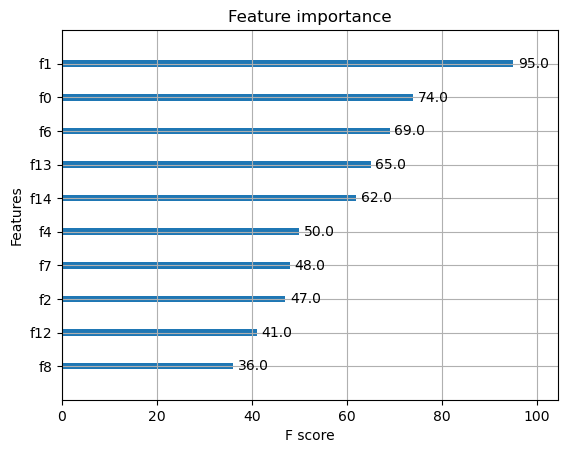

In [28]:
# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(best_model, max_num_features=10)
plt.show()

In [29]:
# Get unique teams from the last season
last_season_year = teams_df['yearID'].max()
teams_last_season = teams_df[teams_df['yearID'] == last_season_year]['teamID'].unique()

# Create DataFrame for upcoming season predictions
prediction_df = pd.DataFrame({'teamID': teams_last_season, 'yearID': last_season_year + 1})

# Get the latest lagged features for each team
latest_features = []
for team in teams_last_season:
    team_data = teams_df[teams_df['teamID'] == team].sort_values('yearID', ascending=False).head(3)
    if len(team_data) < 3:
        continue  # Skip teams with insufficient data
    features = {'teamID': team, 'yearID': last_season_year + 1}
    for lag in range(1, 4):
        for feat in features_to_lag:
            features[f'{feat}_lag{lag}'] = team_data.iloc[lag - 1][feat]
    latest_features.append(features)

prediction_df = pd.DataFrame(latest_features)

In [30]:
# Fill missing values
prediction_df.fillna(0, inplace=True)

In [31]:
X_pred = prediction_df[feature_cols]
X_pred_scaled = scaler.transform(X_pred)

In [32]:
# Predict probabilities
prediction_df['Playoff_Prob'] = best_model.predict_proba(X_pred_scaled)[:, 1]

# Rank teams based on predicted probabilities
prediction_df['Rank'] = prediction_df['Playoff_Prob'].rank(ascending=False, method='first')

# Sort teams by rank
prediction_df.sort_values('Rank', inplace=True)

# Display predicted playoff probabilities
print("Predicted Playoff Probabilities for Upcoming Season:")
print(prediction_df[['teamID', 'Playoff_Prob', 'Rank']])

Predicted Playoff Probabilities for Upcoming Season:
   teamID  Playoff_Prob  Rank
16    ATL      0.545191   1.0
20    LAN      0.542080   2.0
5     HOU      0.539439   3.0
14    TOR      0.538104   4.0
24    PHI      0.525402   5.0
11    SEA      0.475298   6.0
12    TBA      0.454379   7.0
9     NYA      0.452102   8.0
26    SDN      0.442130   9.0
22    MIL      0.425556  10.0
25    PIT      0.413041  11.0
15    ARI      0.408957  12.0
3     CLE      0.402979  13.0
23    NYN      0.397787  14.0
27    SFN      0.380265  15.0
0     BAL      0.375017  16.0
28    SLN      0.369928  17.0
1     BOS      0.366195  18.0
13    TEX      0.362236  19.0
8     MIN      0.358497  20.0
17    CHN      0.349901  21.0
21    MIA      0.321068  22.0
7     LAA      0.312925  23.0
18    CIN      0.297540  24.0
2     CHA      0.282749  25.0
29    WAS      0.277193  26.0
4     DET      0.274831  27.0
6     KCA      0.229604  28.0
10    OAK      0.228468  29.0
19    COL      0.228468  30.0


In [33]:
# Display the predictions DataFrame
print(prediction_df.head())

   teamID  yearID  Win_Percentage_lag1  Run_Differential_lag1  \
16    ATL    2024             0.641975                    231   
20    LAN    2024             0.617284                    207   
5     HOU    2024             0.555556                    129   
14    TOR    2024             0.549383                     75   
24    PHI    2024             0.555556                     81   

    Pythagorean_Win_Percentage_lag1  OPS_lag1  Team_Salary_x_lag1  \
16                         0.636276  0.844759                 0.0   
20                         0.626862  0.794983                 0.0   
5                          0.583989  0.767873                 0.0   
14                         0.552781  0.745242                 0.0   
24                         0.553453  0.764915                 0.0   

    Win_Percentage_lag2  Run_Differential_lag2  \
16             0.623457                    180   
20             0.685185                    334   
5              0.654321                    2

In [34]:
# Select columns to include
if 'name' in prediction_df.columns:
    output_df = prediction_df[['teamID', 'name', 'Playoff_Prob', 'Rank']]
else:
    output_df = prediction_df[['teamID', 'Playoff_Prob', 'Rank']]

In [35]:
# Convert data types for JSON serialization
output_df['teamID'] = output_df['teamID'].astype(str)
output_df['Playoff_Prob'] = output_df['Playoff_Prob'].astype(float)
output_df['Rank'] = output_df['Rank'].astype(int)

In [36]:
# Save the DataFrame to a JSON file
output_df.to_json('playoff_predictions.json', orient='records', indent=4)